# O Algoritmo KMeans

In [87]:
import IPython
IPython.display.Video('cluster-kmeans-example-blobs.mp4',embed=True,html_attributes="loop autoplay controls style='width: 100%'")

## 1. Introdução

Esta é uma implementação do algoritmo KMeans usada para ilustrar seu funcionamento interno.

Neste exemplo, apenas temos a intenção de explicar o algoritmo. Para uso em produção, sugerimos usar uma implementação mais madura como o [sklearn.cluster.KMeans][1].

O artigo [Wikipedia KMeans article][2] tem uma boa explicação da matemática do algoritmo KMeans, bem como variações e referências para maiores detalhes. 


  [1]: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
  [2]: https://en.wikipedia.org/wiki/K-means_clustering

## 2. O Algoritmo

A classe abaixo contém uma implementação comentada do algoritmo que, em resumo faz:
* Mapeia as colunas do dataset de entrada como eixos de um espaço n-dimensional.
* Define "k" centroides, inicialmente retirando com a coordenada de pontos sorteados aleatóriamente;
* Refina os centroids:
 * Associa todos os pontos ao centroide mais próximo usando distância euclidiana;
 * Recaulcula a posição do centroid como a média das posições dos pontos associados;
* Executa este refinamento até que:
  * Nenhum centroid tenha se movido mais que a distância "stop" 
  * Não tenha sido alcançado o limite máximo de execuções "max_iter"

Existe uma exceção quando os dois ou mais centroides acabam muito próximos. Neste caso pode acontecer de nenhum ponto ser associado ao centroide. Neste caso um ponto aleatório será sorteado novamente para subsitiuí-lo. 

In [1]:
import random
import math
import numpy as np
import pandas as pd
from scipy.spatial import distance 
        
def fit_kmeans_iterable( X, stop=0.2, max_iter=20, k=3, verbose=True, anim=False, animFramesBefore=5, animFramesAfter=5 ):
    """Find kmeans clusters for the input dataset
    
    Parameters
    ----------
    X : list of points
        array of points to find the clusters in (accept: list, numpy or pandas)
    stop : float
        stop processing if the clusters move less than this distance
    max_iter : int
        stop processing after this number of iteractions
    k : int
        number of clusters to find
    verbose : bool
        print some messages during processing
    anim: bool : bool = False
        return intermediary frames
    animFramesBefore : int = 30
        repeat first frame 
    animFramesBefore : int = 30
        repeat last frame
    
    Return Values
    -------------
       generator object -> (centroids, centroid_x_points, centroid_x_avgdist, step)             
    
    """    
    
    _centroids = []
    _centroid_x_points = []
    _centroid_x_avgdist = []

    if isinstance(X, pd.DataFrame):
        X = X.to_numpy()

    X = list(X)
        
    _centroids = []
    for centroid_number in range(k):
        _centroids.append( random.sample( X, 1 )[0] )        
    
    if anim:
        stop = stop/10
        max_iter = max_iter*10
    
    iter = 0
       
    change = stop+1
    while True:        

        # preserva os centroides antigos para permitir o cálculo de distância
        centroids_old = list(_centroids)

        if verbose: print( f'centroid={_centroids}' )     
        if verbose: print( f'iteração={iter}' )     

        ##############################################################
        # PARTE 1:
        # Associa os pontos aos centroides e calcula a distância média
        ##############################################################

        # inicializa variáveis 
        _centroid_x_points = []
        _centroid_x_avgdist = []
        for centroid_number in range(k):
            _centroid_x_points.append([])
            _centroid_x_avgdist.append(0)

        for x in X:                

            # calcula a distância para do ponto x para cada centroide
            distances = []            
            for centroid in _centroids:           
                distances.append( distance.euclidean( centroid, x ) )
                           # a distância euclideana é basicamente pitágoras 
                           # (quadrado da hipotenusa = soma dos quadadros dos catetos)
                           # leia-se: sqtr((x1 - x2)^2 + (y1 - y2)^2 (z1 - z2)^2 (...))

            # associa o ponto ao centroide mais próximo
            centroid_number = np.argmin( distances )
            _centroid_x_points[ centroid_number ].append( x )  

            # totaliza as distâncias do ponto x ao centroid
            _centroid_x_avgdist[ centroid_number ] = _centroid_x_avgdist[ centroid_number ] + distances[ centroid_number ]

        # cálculo da distância média
        for centroid_number in range(k):
            if len(  _centroid_x_points[ centroid_number ] ) == 0:
                _centroid_x_avgdist[ centroid_number ] = math.nan
            else:
                _centroid_x_avgdist[ centroid_number ] = _centroid_x_avgdist[ centroid_number ] / len( _centroid_x_points[ centroid_number ] )

        if anim:                
            yield ( _centroids, _centroid_x_points, _centroid_x_avgdist, iter )

        ##############################
        # PARTE 2 
        # Condições de Saída
        ##############################

        # Na iteração anterior nenhum centroid se moveu mais que a distância stop 
        if change < stop:
            yield ( _centroids, _centroid_x_points, _centroid_x_avgdist, iter )
            break
            
        # Não foi alcançado o limite máximo de iterações
        if( iter > max_iter ):
            yield ( _centroids, _centroid_x_points, _centroid_x_avgdist, iter )
            break

        ######################################################
        # PARTE 3 
        # Move o centroide para o centro dos pontos associados
        ######################################################
        iter = iter + 1
        change = 0.0                
        # para cada centroid calcula a nova posição 
        for centroid_number in range(k):            
            points = _centroid_x_points[ centroid_number ]

            if len(points) > 0:
                new_center = np.average( points, axis=0 )
            else:
                new_center = random.sample( X, 1 )[0]
        
            if anim:
                new_center = np.average( [ new_center, _centroids[ centroid_number ] ], axis=0, weights=[0.1,0.9] )
            
            
                
            if verbose: print( f' n={centroid_number} points={len(points)} c={new_center}' )
                
            _centroids[ centroid_number ] = new_center

            change = max( 
                distance.euclidean( 
                    _centroids[centroid_number], 
                    centroids_old[centroid_number]
                ), 
                change 
            )

def fit_kmeans( X, stop=0.2, max_iter=20, k=3, verbose=True, anim=False, animFramesBefore=30, animFramesAfter=30 ):
    """Find kmeans clusters for the input dataset
    
    Parameters
    ----------
    X : list of points
        array of points to find the clusters in (accept: list, numpy or pandas)
    stop : float
        stop processing if the clusters move less than this distance
    max_iter : int
        stop processing after this number of iteractions
    k : int
        number of clusters to find
    verbose : bool
        print some messages during processing
    anim: bool : bool = False
        return intermediary frames
    animFramesBefore : int = 30
        repeat first frame 
    animFramesBefore : int = 30
        repeat last frame
    
    Return Values
    -------------
       generator object -> (centroids, centroid_x_points, centroid_x_avgdist, step)             
    
    """
    
    if anim:
        return list( fit_kmeans_iterable(X, stop, max_iter, k, verbose, True, animFramesBefore, animFramesAfter ) )
    else:
        return next( fit_kmeans_iterable(X, stop, max_iter, k, verbose, False, animFramesBefore, animFramesAfter ) )
    
   

In [48]:
help(fit_kmeans)

Help on function fit_kmeans in module __main__:

fit_kmeans(X, stop=0.2, max_iter=20, k=3, verbose=True, anim=False, animFramesBefore=30, animFramesAfter=30)
    Find kmeans clusters for the input dataset
    
    Parameters
    ----------
    X : list of points
        array of points to find the clusters in (accept: list, numpy or pandas)
    stop : float
        stop processing if the clusters move less than this distance
    max_iter : int
        stop processing after this number of iteractions
    k : int
        number of clusters to find
    verbose : bool
        print some messages during processing
    anim: bool : bool = False
        return intermediary frames
    animFramesBefore : int = 30
        repeat first frame 
    animFramesBefore : int = 30
        repeat last frame
    
    Return Values
    -------------
       generator object -> (centroids, centroid_x_points, centroid_x_avgdist, step)



# 3.1 Testes do Algoritmo

Este bloco gera a animação do início do notebook

In [2]:
def bloco():
    
    %matplotlib inline
    from sklearn import datasets;
    import matplotlib.pyplot as plt
    from matplotlib.animation import FuncAnimation
    import IPython
    
    random.seed(13)
    
    X, yTrue = datasets.make_blobs(
        n_samples=1000,
        centers=[ [random.uniform(0,32), random.uniform(0,15) ] for i in range(7)], 
        n_features=2,
        random_state=5
    )        
  
    random.seed(16)
  
    fig = plt.figure(
        figsize=(12,5),
        dpi=100,
        frameon=True
    ) 

    def anim_init():
        print('init')

    def anim_update( data ):     
        centroids, centroid_x_points, centroid_x_avgdist, step = data 
        print(step, end=';')
        
        hsv = plt.cm.get_cmap('hsv', len(centroid_x_points)+1)
        
        plt.clf()
        plt.title( f"Teste do KMeans com makeblobs (step={step/10})")      
        #plt.xticks(())
        #plt.yticks(())
        #plt.box(False)

        ax = fig.subplots()
        #ax.set_axis_off()
        plt.subplots_adjust(left=-0.001, right=1.001, top=0.9, bottom=-0.005)
        #fig.patch.set_visible(False)
        #ax.patch.set_visible(False)
        #ax.get_xaxis().set_ticks([])
        #ax.get_yaxis().set_ticks([])
        #ax.set_xlabel('random y (makeblobs)')
        #ax.set_ylabel('random y (makeblobs)')
        ax.set_xlim([0,32])
        ax.set_ylim([0,15])

        res = []

        ax.scatter(                        
                [ X[j][0] for j in range(len(X)) ],
                [ X[j][1] for j in range(len(X)) ],
                color='#c0c0c0',
                marker='.',
                s=4,
                label=f'Sem cluster'
            )
        
        for cluster_id in range(0,len(centroid_x_points)):
            
            ax.scatter(                        
                [ centroid_x_points[cluster_id][j][0] for j in range(len(centroid_x_points[cluster_id])) ],
                [ centroid_x_points[cluster_id][j][1] for j in range(len(centroid_x_points[cluster_id])) ],
                color=hsv(cluster_id),
                marker='o',
                s=16,
                label=f'Cluster {cluster_id}'
            )
            
            ax.add_patch( plt.Circle((centroids[cluster_id][0],centroids[cluster_id][1]), fill=False, radius=centroid_x_avgdist[cluster_id], color=hsv(cluster_id) ) )
            
            ax.scatter(                        
                [ centroids[cluster_id][0] ],
                [ centroids[cluster_id][1] ],
                color='#000000',
                marker='o',
                s=32
            )
            
            
        ax.legend()

    anim = FuncAnimation(
        fig=fig,
        func=anim_update,
        frames=fit_kmeans_iterable(X,k=7,animFramesAfter=30,animFramesBefore=3,anim=True,verbose=False),
        save_count=140,
        interval=500,
        blit=False
    )
    video = anim.save('cluster-kmeans-example-blobs.mp4')
    #video = anim.to_html5_video()
    #return IPython.display.HTML(video)
    #IPython.display.clear_output(wait=True)       
    #IPython.display.display(html)

    plt.close() 
    
    #IPython.display.clear_output(wait=True)       
    
bloco()

0;0;1;2;3;4;5;6;7;8;9;10;11;12;13;14;15;16;17;18;19;20;21;22;23;24;25;26;27;28;29;30;31;32;33;34;35;36;37;38;39;40;41;42;42;

# 4. O exemplo com a base de casos x mortes por covid19 nos municípios americanos

## 4.1. Importação dos dados 

Os dados usados usados nesta demonstração são de casos e mortes por covid19 por município dos Estados Unidos. 

In [1]:
def bloco():
    
    global df
    
    from datetime import datetime
    import pandas as pd
    import os
    pd.options.display.max_columns = None
        
    if os.path.isfile('/kaggle/input/us-counties-covid-19-dataset/us-counties.csv'):
        file = '/kaggle/input/us-counties-covid-19-dataset/us-counties.csv'
    elif os.path.isfile( 'dataset-covid19/us-counties-covid-19-dataset.csv' ):
        file = 'dataset-covid19/us-counties-covid-19-dataset.csv'
    else:
        raise Exception('Por favor, inclua o arquivo de dados em dataset-covid19/us-counties-covid-19-dataset.csv')
        
    df = pd.read_csv( file,
             #nrows=1000 
        )

    df.insert( 1, "wday", df['date'].apply( lambda x: int(datetime.strptime(x,'%Y-%m-%d').strftime('%w')) ) )
    df.insert( 1, "mday", df['date'].apply( lambda x: int(datetime.strptime(x,'%Y-%m-%d').strftime('%d')) ) )
   
    df = df.dropna()
   
    return df
    
bloco()

,date,mday,wday,county,state,fips,cases,deaths
0,2020-01-21,21,2,Snohomish,Washington,53061.0,1,0
1,2020-01-22,22,3,Snohomish,Washington,53061.0,1,0
2,2020-01-23,23,4,Snohomish,Washington,53061.0,1,0
3,2020-01-24,24,5,Cook,Illinois,17031.0,1,0
4,2020-01-24,24,5,Snohomish,Washington,53061.0,1,0
...,...,...,...,...,...,...,...,...
45875,2020-04-09,9,4,Sublette,Wyoming,56035.0,1,0
45876,2020-04-09,9,4,Sweetwater,Wyoming,56037.0,6,0
45877,2020-04-09,9,4,Teton,Wyoming,56039.0,50,0
45878,2020-04-09,9,4,Uinta,Wyoming,56041.0,4,0


## 4.2. Modelo
No exemplo abaixo, procuramos agrupamentos entre casos e mortes.

A animação abaixo ilustra como os pontos vão se reposicionando. Em cada iteração o modelo encontra os pontos mais próximos do centroide e reposiciona o centroide no centro dos pontos selecionados. Isto faz o modelo espalhar os pontos.


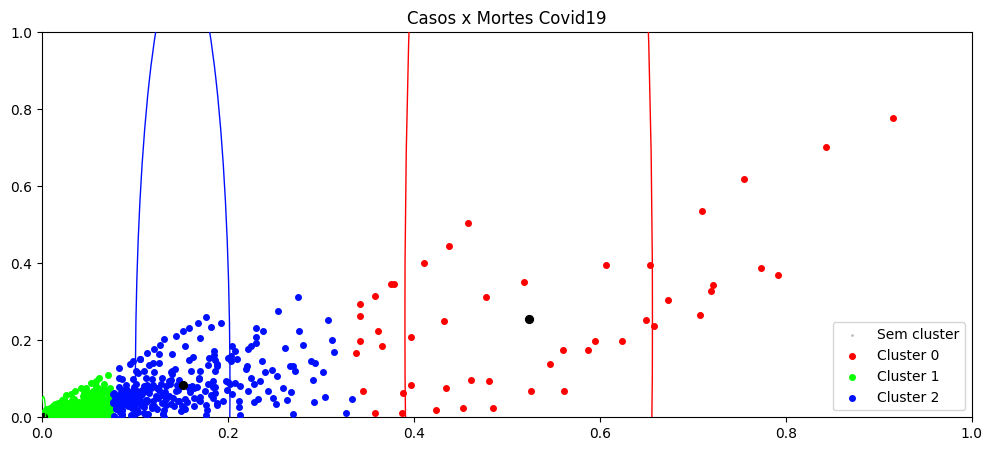

In [99]:
def bloco():
    
    %matplotlib inline
    from sklearn import datasets;
    import matplotlib.pyplot as plt
    from matplotlib.animation import FuncAnimation
    import IPython
    
    
    X = df[ ['cases', 'deaths' ] ].to_numpy()
  
    random.seed(16)
  
    fig = plt.figure(
        figsize=(12,5),
        dpi=100,
        frameon=True
    ) 

    centroids, centroid_x_points, centroid_x_avgdist, step = fit_kmeans(
        X,k=3,animFramesAfter=30,animFramesBefore=3,anim=False,verbose=False
    )
    

    hsv = plt.cm.get_cmap('hsv', len(centroid_x_points)+1)

    plt.clf()
    plt.title( f"Casos x Mortes Covid19")      
    #plt.xticks(())
    #plt.yticks(())
    #plt.box(False)

    ax = fig.subplots()
    ax.set_axis_off()
    #plt.subplots_adjust(left=-0.001, right=1.001, top=0.9, bottom=-0.005)
    #fig.patch.set_visible(False)
    #ax.patch.set_visible(False)
    #ax.get_xaxis().set_ticks([])
    #ax.get_yaxis().set_ticks([])
    ax.set_xlabel('casos')
    ax.set_ylabel('mortes')
    ax.set_xlim([0,22000])
    ax.set_ylim([0,1000])
    #plt.yscale('log')
    #plt.xscale('log') 

    res = []

    ax.scatter(                        
            [ X[j][0] for j in range(len(X)) ],
            [ X[j][1] for j in range(len(X)) ],
            color='#c0c0c0',
            marker='.',
            s=4,
            label=f'Sem cluster'
        )

    for cluster_id in range(0,len(centroid_x_points)):

        ax.scatter(                        
            [ centroid_x_points[cluster_id][j][0] for j in range(len(centroid_x_points[cluster_id])) ],
            [ centroid_x_points[cluster_id][j][1] for j in range(len(centroid_x_points[cluster_id])) ],
            color=hsv(cluster_id),
            marker='o',
            s=16,
            label=f'Cluster {cluster_id}'
        )

        ax.add_patch( plt.Circle((centroids[cluster_id][0],centroids[cluster_id][1]), fill=False, radius=centroid_x_avgdist[cluster_id], color=hsv(cluster_id) ) )

        ax.scatter(                        
            [ centroids[cluster_id][0] ],
            [ centroids[cluster_id][1] ],
            color='#000000',
            marker='o',
            s=32
        )


    ax.legend()
    
    plt.show()
    
    
bloco()

## 5 Considerações Finais

Esquecendo por um minuto como o Kmeans funciona, o que eu vejo são possíveis agrupamentos com significados em linhas. Existem três grandes tentâculos na área vermelha. Na área azul parecem haver mais dois. Estes tentáculos me parecem muito mais significativos para comparar municípios que tem índices de mortes menores e podem ser encontradas característiacas no mundo real que expliquem isto. Melhores hospitais? Diferenças Culturais? Testagem mais ampla que aumenta o denominador? Cidades mais afastadas que demoram a receber as novas variantes, portanto se beneficiam da experiência dos pioneiros?

Mas o algoritmo não tem condições de detectar isto pois forma círculos. Da forma que está o K-Means detectou foram zonas mais ou menos baseadas na quantidade de casos. Aumentando o "k" identificamos apenas mais zonas desta mesma forma, subdividindo mais o gráfico.

In [ ]:
#

In [151]:
import os
os.remove("tmp.gif")